<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/imagesCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 2 – Image Processing:
image preprocessing is an essential stage before any data analysis or machine-learning model training.

The main goal is to make sure that all images are clean, consistent, and properly formatted for model input.

This includes verifying image files, correcting errors, resizing them to a uniform size, normalizing their pixel values, and applying image augmentation to increase dataset diversity.

# Step 1 – Setup and Imports:
In this step, I set up the environment and import all the required Python libraries such as pandas, numpy, and Pillow.

These libraries allow me to load, analyze, and process the images efficiently.
I also define configuration variables like image size and output folders, which control how the images will be processed throughout the notebook.

In [ ]:
# === Cell 1: Setup & Imports ===
!pip install -q pillow numpy pandas tqdm

import io, os, zipfile, shutil, csv, sys
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# ---- Config  ----
RESIZE_TO = (224, 224)
IMAGES_ROOT = "images"   # where the unzipped images will live
CLEAN_DIR   = "clean_images"  # output directory for processed images
MISSING_CSV = "missing_images.csv"  # log of missing/corrupt files
SAVE_NUMPY  = True        # also save normalized arrays as .npy

# Step 2 – Upload CSV and ZIP:
Here I upload two main files:


*   the CSV file, which contains the dataset information including the image_file column (the name of each image),
*   the ZIP file that contains all the original images.


This step ensures that the data is available in the Colab environment for extraction and further processing.

In [ ]:
# === Cell 2: Upload CSV and ZIP ===
from google.colab import files
uploaded = files.upload()   # Choose: CSV and the images ZIP

# Identify CSV and ZIP from uploads
csv_path = None
zip_path = None
for name in uploaded:
    if name.lower().endswith(".csv"):
        csv_path = name
    if name.lower().endswith(".zip"):
        zip_path = name

assert csv_path is not None, "Please upload your CSV file."
assert zip_path is not None, "Please upload your images .zip file."

print("CSV:", csv_path)
print("ZIP:", zip_path)

Saving saudi_food_images.zip to saudi_food_images.zip
Saving SaudiFoodFile_standardized_consistent.csv to SaudiFoodFile_standardized_consistent.csv
CSV: SaudiFoodFile_standardized_consistent.csv
ZIP: saudi_food_images.zip


# Step 3 – Extract Images:
In this step, I extract all images from the uploaded ZIP file into a working folder named images/.

This allows me to access each image directly from the folder.
A quick preview of a few filenames is displayed to confirm that the extraction worked correctly.

In [ ]:
# === Cell 3: Extract images ===
# Clean old folders if re-running
if os.path.exists(IMAGES_ROOT):
    shutil.rmtree(IMAGES_ROOT)
os.makedirs(IMAGES_ROOT, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(IMAGES_ROOT)

# Quick peek
sample_list = []
for root, _, files_ in os.walk(IMAGES_ROOT):
    for f in files_:
        sample_list.append(os.path.join(root, f))
        if len(sample_list) >= 5:
            break
    if len(sample_list) >= 5:
        break

print(f"Extracted under: {IMAGES_ROOT}")
print("Sample files:", sample_list[:5])

Extracted under: images
Sample files: ['images/saudi_food_images/hummus.png', 'images/saudi_food_images/lamb_tagine.png', 'images/saudi_food_images/umm_ali. Png', 'images/saudi_food_images/chicken_madhbi.png', 'images/saudi_food_images/lotus_sweet.png']


# Step 4 – Read CSV and Validate Column:
Here I load the dataset CSV into a pandas DataFrame and confirm which column holds the image filenames.

For this project, the correct column is image_file.

This validation ensures that each record in the CSV can be linked to its corresponding image for processing.

In [ ]:
# === Cell 4: Load CSV and check column ===
df = pd.read_csv(csv_path)
col = "image_file"  # confirmed column name from your dataset
print(f"Using image filename column: '{col}'")
print(df[[col]].head())

Using image filename column: 'image_file'
                        image_file
0                almond_coffee.jpg
1              hejaz_shakshuka.jpg
2  meat_kabsa_and_daqoos_salad.jpg
3                        kleja.jpg
4                chicken_kabsa.jpg


# Step 5 – Image Lookup Function:
This section defines a helper function, safe_find(), which locates image files inside the extracted folder.

It searches for filenames in a case-insensitive way and ensures the correct image is found even if there are minor differences in name formatting.


In [ ]:
# === Cell 5: Utility to find images robustly ===
# Build a lookup of normalized filenames (lowercase, basename only) -> full path
all_files = {}
for root, _, files_ in os.walk(IMAGES_ROOT):
    for f in files_:
        all_files[os.path.basename(f).lower()] = os.path.join(root, f)

def safe_find(full_or_base_name: str):
    """
    Try exact basename match (case-insensitive).
    If path-like input is given in CSV, take only the basename for matching.
    """
    if not isinstance(full_or_base_name, str):
        return None
    base = os.path.basename(full_or_base_name).lower().strip()
    return all_files.get(base, None)

# Step 6 – Main Image Processing Loop:
This is the main step where the actual processing happens for every image listed in the CSV.

The code performs the following actions:

	•	Saves the processed copies to a new folder called clean_images/.


*   Verifies if the image exists; logs missing ones.
*   Opens each image safely and skips corrupted files.


* Converts non-RGB images (like grayscale) to RGB to maintain consistency.

*  Resizes all images to 224×224 pixels.


*   Saves the processed copies to a new folder called clean_images/.






At the end, a summary is printed showing how many images were successfully processed, how many were missing, and how many were converted.

In [ ]:
# === Cell 6: Main processing loop ===
os.makedirs(CLEAN_DIR, exist_ok=True)

missing_rows = []
ok_count = 0
missing_count = 0
corrupt_count = 0
converted_to_rgb = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    rel = row[col]
    path = safe_find(rel)
    if path is None or (not os.path.exists(path)):
        missing_rows.append({
            "index": idx,
            "image_file": rel,
            "issue": "missing"
        })
        missing_count += 1
        continue

    # Try to open via PIL
    try:
        with Image.open(path) as im:
            # Convert non-RGB to RGB
            if im.mode != "RGB":
                im = im.convert("RGB")
                converted_to_rgb += 1

            # Resize
            im = im.resize(RESIZE_TO, Image.BILINEAR)

            # Save to CLEAN_DIR preserving basename
            out_name = os.path.basename(path)
            out_path = os.path.join(CLEAN_DIR, out_name)
            im.save(out_path, format="JPEG", quality=95)

            ok_count += 1

    except (UnidentifiedImageError, OSError) as e:
        missing_rows.append({
            "index": idx,
            "image_file": rel,
            "issue": f"corrupt_or_unreadable: {type(e).__name__}"
        })
        corrupt_count += 1

print("Done.")
print(f"OK processed: {ok_count}")
print(f"Missing:      {missing_count}")
print(f"Corrupt:      {corrupt_count}")
print(f"Converted to RGB (non-RGB originally): {converted_to_rgb}")

Processing:  63%|██████▎   | 179/285 [00:03<00:01, 60.24it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing: 100%|██████████| 285/285 [00:06<00:00, 43.95it/s]

Done.
OK processed: 284
Missing:      1
Corrupt:      0
Converted to RGB (non-RGB originally): 95


# Step 7 – Save Log and Summary:
This step saves all missing or corrupted image details into a CSV file named missing_images.csv.

It also prints a summary of image processing results

In [ ]:
# === Cell 7: Save missing_images.csv and show summary ===
log_df = pd.DataFrame(missing_rows, columns=["index", "image_file", "issue"])
log_df.to_csv(MISSING_CSV, index=False, encoding="utf-8-sig")

summary = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "total_rows_in_csv": int(len(df)),
    "ok_processed": int(ok_count),
    "missing": int(missing_count),
    "corrupt": int(corrupt_count),
    "converted_to_rgb": int(converted_to_rgb),
    "resize_to": f"{RESIZE_TO[0]}x{RESIZE_TO[1]}",
    "clean_dir": CLEAN_DIR,
    "log_csv": MISSING_CSV,
}
for k,v in summary.items():
    print(f"{k}: {v}")

timestamp: 2025-10-11T12:47:20
total_rows_in_csv: 285
ok_processed: 284
missing: 1
corrupt: 0
converted_to_rgb: 95
resize_to: 224x224
clean_dir: clean_images
log_csv: missing_images.csv


# Step 8 – Normalize Pixel Values:
After the images are cleaned and resized, I normalize all pixel values to be between 0 and 1.

This transformation ensures that all images are on the same scale, making it easier and faster for models to learn.

The normalized dataset is saved as clean_images_normalized.npy — a compact NumPy file that stores all image arrays efficiently and is ready for use in training or analysis.

In [ ]:
# === Cell 8: Normalization step ===
#This step prepares cleaned images so they can be used in machine-learning or deep-learning models.

clean_paths = []
for f in os.listdir(CLEAN_DIR):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
        clean_paths.append(os.path.join(CLEAN_DIR, f))
clean_paths.sort()

arrays = []
for p in tqdm(clean_paths, desc="Normalizing"):
    with Image.open(p) as im:
        arr = np.asarray(im, dtype=np.float32) / 255.0  # [0,1]
        arrays.append(arr)

X = np.stack(arrays, axis=0) if arrays else np.empty((0, RESIZE_TO[1], RESIZE_TO[0], 3))
print("Normalized array shape:", X.shape)

if SAVE_NUMPY:
    np.save("clean_images_normalized.npy", X)
    print("Saved: clean_images_normalized.npy")

Normalizing: 100%|██████████| 271/271 [00:00<00:00, 854.47it/s]


Normalized array shape: (271, 224, 224, 3)
Saved: clean_images_normalized.npy


This step is used to verify that the final processed dataset is correct and consistent before using it in any model training.
After normalization, it’s important to make sure all images have been properly prepared and that no hidden issues remain.

In this step, we:
Check the pixel value range to confirm all values are between 0 and 1, ensuring normalization worked correctly.

Check the data type (should be float32) because most machine-learning models require floating-point inputs.
  
Check the image shape and channels to verify that every image has the same size (e.g., 224×224) and three color channels (RGB).


These checks guarantee that the dataset is standardized, consistent, and ready for modeling. It helps catch problems early — such as unnormalized pixels, grayscale images, or inconsistent image sizes — which could otherwise cause errors or poor model performance later.

In [ ]:
# === Cell 9: Quick sanity checks ===
# Count channels and unique shapes in the normalized array
if SAVE_NUMPY and 'X' in globals() and X.size > 0:
    print("min/max:", float(X.min()), float(X.max()))
    print("dtype:", X.dtype)
    unique_shapes = {str(X.shape[1:])}
    print("unique (H,W,C) shapes:", unique_shapes)

min/max: 0.0 1.0
dtype: float32
unique (H,W,C) shapes: {'(224, 224, 3)'}


In [ ]:
import numpy as np

# Load your normalized image dataset
X = np.load("clean_images_normalized.npy")

print("Shape:", X.shape)
print("Data type:", X.dtype)

Shape: (271, 224, 224, 3)
Data type: float32


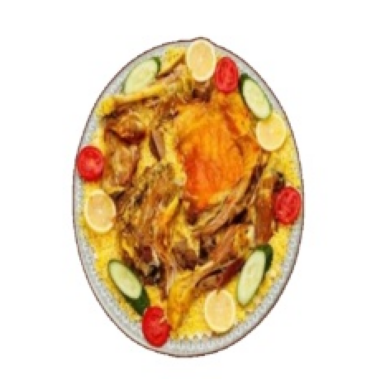

In [ ]:
import matplotlib.pyplot as plt

# Show the first image
plt.imshow(X[0])
plt.axis('off')
plt.show()

In [ ]:
print("Min:", X.min())
print("Max:", X.max())

Min: 0.0
Max: 1.0


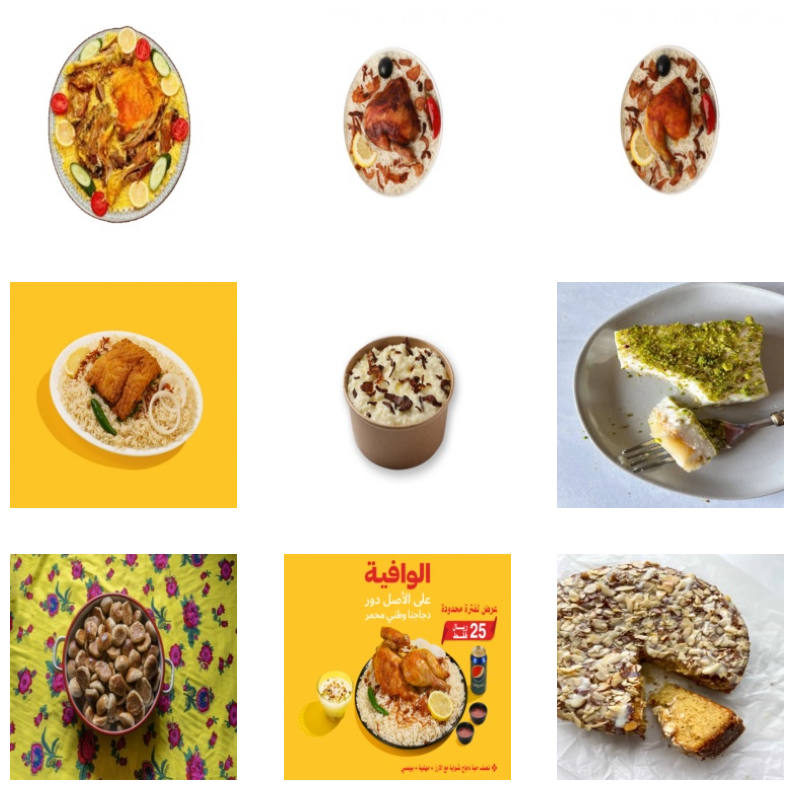

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()